# Interpretability Analysis

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

sys.path.append(os.path.abspath('..'))

from src.dataset import load_data
from src.interpretability.feature_importance.integrated_gradients import LLMIsDefault
from src.interpretability.viz.utils import plot_token_importance, plot_text_heatmap, plot_latent_space
from src.interpretability.latent_analysis.clustering import compute_tsne, compute_pca
from src.interpretability.latent_analysis.probing import ProbingClassifier
from src.interpretability.attention.visualization import get_attention_weights, plot_attention_heatmap
from src.interpretability.counterfactuals.generation import sensitivity_check
from src.model_utils import get_latest_checkpoint

%matplotlib inline

## Load Model & Data

In [2]:
DEFAULT_MODEL_ID = "google/medgemma-1.5-4b-it"
# Check for checkpoints in the parent directory
CHECKPOINT_DIR = "../checkpoints"

model_id = get_latest_checkpoint(DEFAULT_MODEL_ID, checkpoint_dir=CHECKPOINT_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Loading tokenizer from base model: {DEFAULT_MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL_ID)

print(f"Loading model: {model_id}...")

# Check if model_id is a PEFT adapter (contains adapter_config.json)
is_adapter = False
if os.path.isdir(model_id) and "adapter_config.json" in os.listdir(model_id):
    is_adapter = True

if is_adapter:
    from peft import PeftModel
    print(f"Detected PEFT adapter at {model_id}. Loading base model {DEFAULT_MODEL_ID} first...")
    base_model = AutoModelForCausalLM.from_pretrained(
        DEFAULT_MODEL_ID, 
        dtype=torch.bfloat16, 
        device_map="auto",
        attn_implementation="eager"
    )
    model = PeftModel.from_pretrained(base_model, model_id)
else:
    model = AutoModelForCausalLM.from_pretrained(
        model_id, 
        dtype=torch.bfloat16, 
        device_map="auto",
        attn_implementation="eager"
    )

# Enable Gradient Checkpointing to save memory during IG
model.gradient_checkpointing_enable()
model.eval()
print("Model loaded with gradient checkpointing enabled.")

Found latest checkpoint: ../checkpoints/final_medgemma_model
Loading tokenizer from base model: google/medgemma-1.5-4b-it...
Loading model: ../checkpoints/final_medgemma_model...
Detected PEFT adapter at ../checkpoints/final_medgemma_model. Loading base model google/medgemma-1.5-4b-it first...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded with gradient checkpointing enabled.


In [3]:
_, _, test_df = load_data('../tcga_reports_valid.csv')
print(f"Loaded {len(test_df)} test samples.")
test_df.head(2)

Loaded 1479 test samples.


,patient_id,cancer_type,study_name,icd_o_3_site,icd_o_3_histology,icd_o_3_behavior,text
3778,TCGA-CS-5394,LGG,Brain Lower Grade Glioma,C719,9401,3,FINAL DIAGNOSIS: 1. LEFT FRONTAL TUMOR: ANAPLA...
2402,TCGA-B0-4848,KIRC,Kidney renal clear cell carcinoma,C649,8310,3,"FINAL DIAGNOSIS. PART 1: LEFT KIDNEY, RADICAL ..."


## Latent Space Analysis

Extracting embeddings...


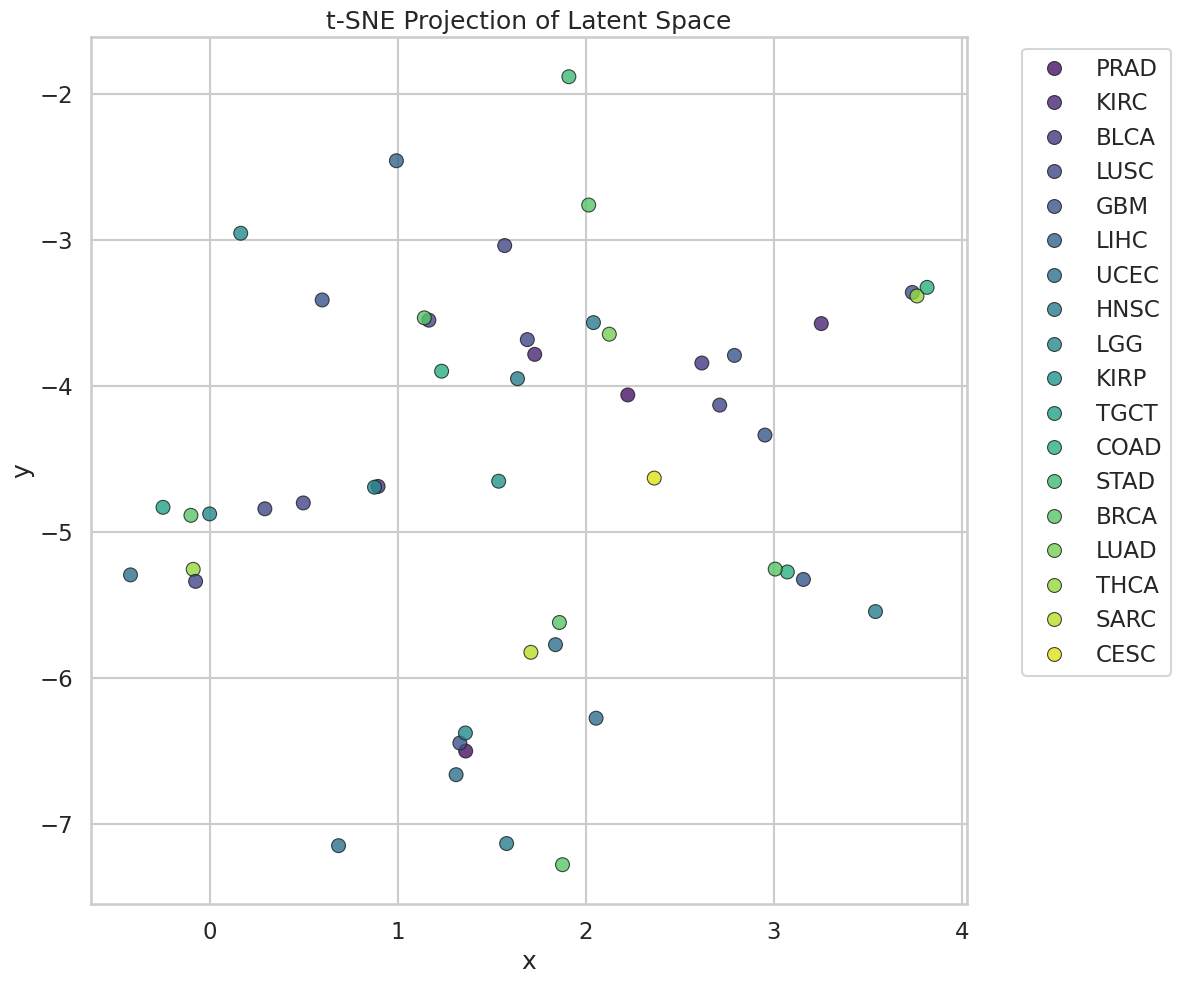

In [6]:
batch_size = 50
batch = test_df.sample(batch_size, random_state=42)
activations = []
labels = []

print("Extracting embeddings...")
for idx, row in batch.iterrows():
    txt = row['text'][:500]
    inp = tokenizer(txt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model(**inp, output_hidden_states=True)
    activations.append(out.hidden_states[-1][:, -1, :].float().cpu().numpy())
    labels.append(row['cancer_type'])

activations = np.vstack(activations)

try:
    tsne_emb = compute_tsne(activations, perplexity=min(30, len(activations)-1))
    plot_latent_space(tsne_emb, labels, method="t-SNE")
except Exception as e:
    print(f"t-SNE failed: {e}")

## Attention Visualization

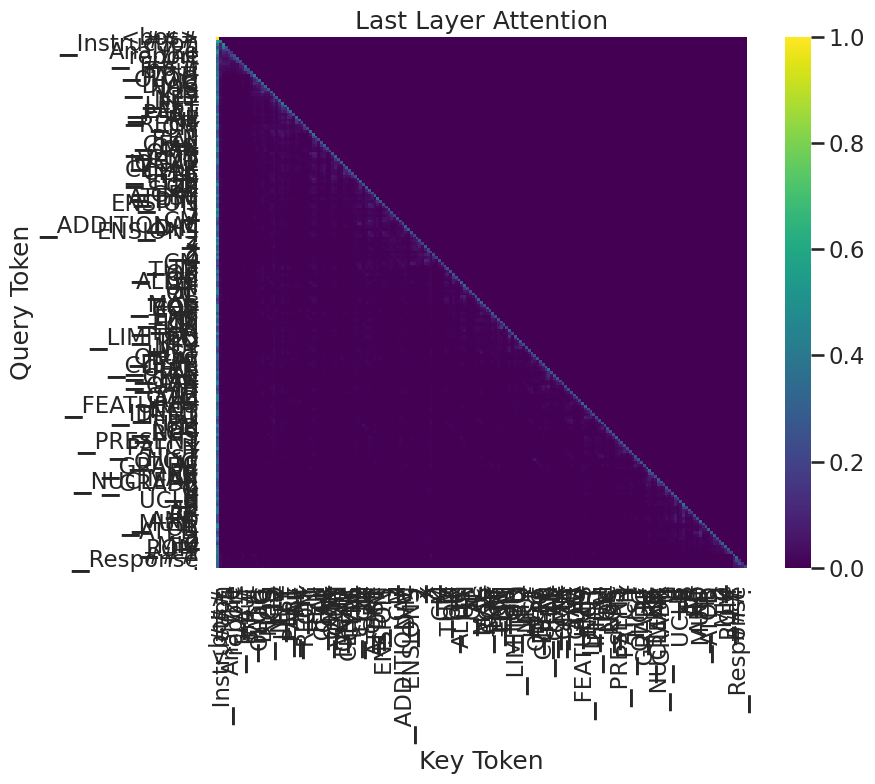

In [7]:
attn, tokens = get_attention_weights(model, tokenizer, prompt, layer_idx=-1)
plot_attention_heatmap(attn, tokens, title="Last Layer Attention")

## Counterfactual Analysis

In [ ]:
template = "DIAGNOSIS: {INSERT} TUMOR. BIOPSY PERFORMED."
candidates = ["KIDNEY", "LUNG", "BRAIN", "PROSTATE"]

results = sensitivity_check(model, tokenizer, template, candidates)
pd.DataFrame(results)